In [1]:
# !pip install tf2onnx
# !pip install onnxruntime
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 276.5/311.2 kB 8.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/1.7 MB 5.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 0.8/1.7 MB 7.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 1.1/1.7 MB 8.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.7 MB/s eta 0:00:00


  Attempting uninstall: keras
    Found existing installation: keras 3.1.1


    Uninstalling keras-3.1.1:


      Successfully uninstalled keras-3.1.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os, gc
import tensorflow as tf
import pandas as pd
import numpy as np
import copy
from joblib import load, dump

import librosa.display
import matplotlib.pyplot as plt

# import albumentations as A

from tqdm import tqdm

from scipy import signal as sci_signal
import torch

from sklearn.model_selection import train_test_split
import cv2

img_shape = 256

In [3]:
import ast

def parse_array(x):
    return ast.literal_eval(x)

df = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
df = df.drop(columns= ['type', 'longitude', 'latitude', 'scientific_name', 'common_name', 'author', 'license', 'url'] )
df.to_csv('data.csv', index=False)

In [4]:
train = pd.read_csv('/kaggle/working/data.csv', converters={'secondary_labels': parse_array})
train.head()

,primary_label,secondary_labels,rating,filename
0,asbfly,[],5.0,asbfly/XC134896.ogg
1,asbfly,[],2.5,asbfly/XC164848.ogg
2,asbfly,[],2.5,asbfly/XC175797.ogg
3,asbfly,[],4.0,asbfly/XC207738.ogg
4,asbfly,[],4.0,asbfly/XC209218.ogg


In [5]:
train = train[train.rating>=1]

In [6]:
columns = pd.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv').columns[1:]
print(len(columns))

182


In [7]:
label_dict = {}
for i in range(len(columns)):
    label_dict[columns[i]] = i

In [8]:
train.head()

,primary_label,secondary_labels,rating,filename
0,asbfly,[],5.0,asbfly/XC134896.ogg
1,asbfly,[],2.5,asbfly/XC164848.ogg
2,asbfly,[],2.5,asbfly/XC175797.ogg
3,asbfly,[],4.0,asbfly/XC207738.ogg
4,asbfly,[],4.0,asbfly/XC209218.ogg


In [9]:
labels = []
for i in tqdm(train.values):
    temp = np.zeros((182))
    
    if len(i[1]) > 0:
        for j in range(len(i[1])):
            if i[1][j] in label_dict:
                temp[label_dict[i[1][j]]] = 0.1
    
    temp[label_dict[i[0]]] = 1    
    labels.append(temp)
    
labels = np.vstack(labels)

  0%|          | 0/23815 [00:00<?, ?it/s]

100%|██████████| 23815/23815 [00:00<00:00, 438891.65it/s]

In [10]:
temp = np.sum(labels, axis = 1)
np.max(temp), np.min(temp), np.where(temp==1)[0].shape

(1.7000000000000002, 1.0, (22075,))

In [11]:
print(train.shape, labels.shape)

(23815, 4) (23815, 182)


In [12]:
def get_spects(auds):
    '''5 scond audio files
    '''
    audios = []
    for row in (auds):
        
        mean_signal = np.nanmean(row)
        audio_data = np.nan_to_num(row, nan=mean_signal) if np.isnan(row).mean() < 1 else np.zeros_like(row)

        frequencies, times, spec_data = sci_signal.spectrogram(
            audio_data, 
            fs=  32000 ,
            nfft= 1095, 
            nperseg= 412, 
            noverlap= 100, 
            window='hann'
        )
        
        valid_freq = (frequencies >= 100) & (frequencies <= 15000)
        spec_data = spec_data[valid_freq, :]

        spec_data = np.log10(spec_data + 1e-20)

        spec_data = spec_data - spec_data.min()
        spec_data = spec_data / spec_data.max()
        
        # 256
        spec_data = cv2.resize(spec_data, (img_shape, img_shape), interpolation=cv2.INTER_AREA)
        audios.append(spec_data)
        
    audios = np.asarray(audios)
    return audios

In [13]:
from joblib import Parallel, delayed

three = False
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data = train.values, y_data = labels, batch_size=32, ):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size  
        self.indices = np.arange(len(self.x_data))
    
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    def aug(self,x, y):
        return x,y
    
    def __getitem__(self, index):
        
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        y_batch = self.y_data[batch_indices]
        x_batch, y_batch = self.getSpecs(batch_indices, y_batch)
        
        x_batch = x_batch.reshape(-1,img_shape,img_shape,1)
        
        return x_batch, y_batch
    
    def getSpecs(self, batch_indices, y_batch):
        sr = 32000
        train_path = '/kaggle/input/birdclef-2024/train_audio/'

        x = []
        oup = []
        for k,i in enumerate(batch_indices):
            audio_file = train_path + self.x_data[i][3]
            y, _ = librosa.load(audio_file, sr=sr)

            total_duration = len(y) / sr
            while total_duration < 5:
                y = np.concatenate([y, y])
                total_duration = len(y) / sr
            start_idx = int((total_duration / 2 - 2.5) * sr)
            middle_5_seconds = y[start_idx:start_idx + 5 * sr]
            early_5_sec = y[0:5*sr]
            if len(y)>(10*sr) and three:
                second_5_sec = y[5*sr:10*sr]
                x.append(second_5_sec)
                oup.append([y_batch[k]]*3)
            else:
                oup.append([y_batch[k]]*2)

            x.append(middle_5_seconds)
            x.append(early_5_sec)
            
        return get_spects(x), np.vstack(oup)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

(64, 256, 256, 1) (64, 182)


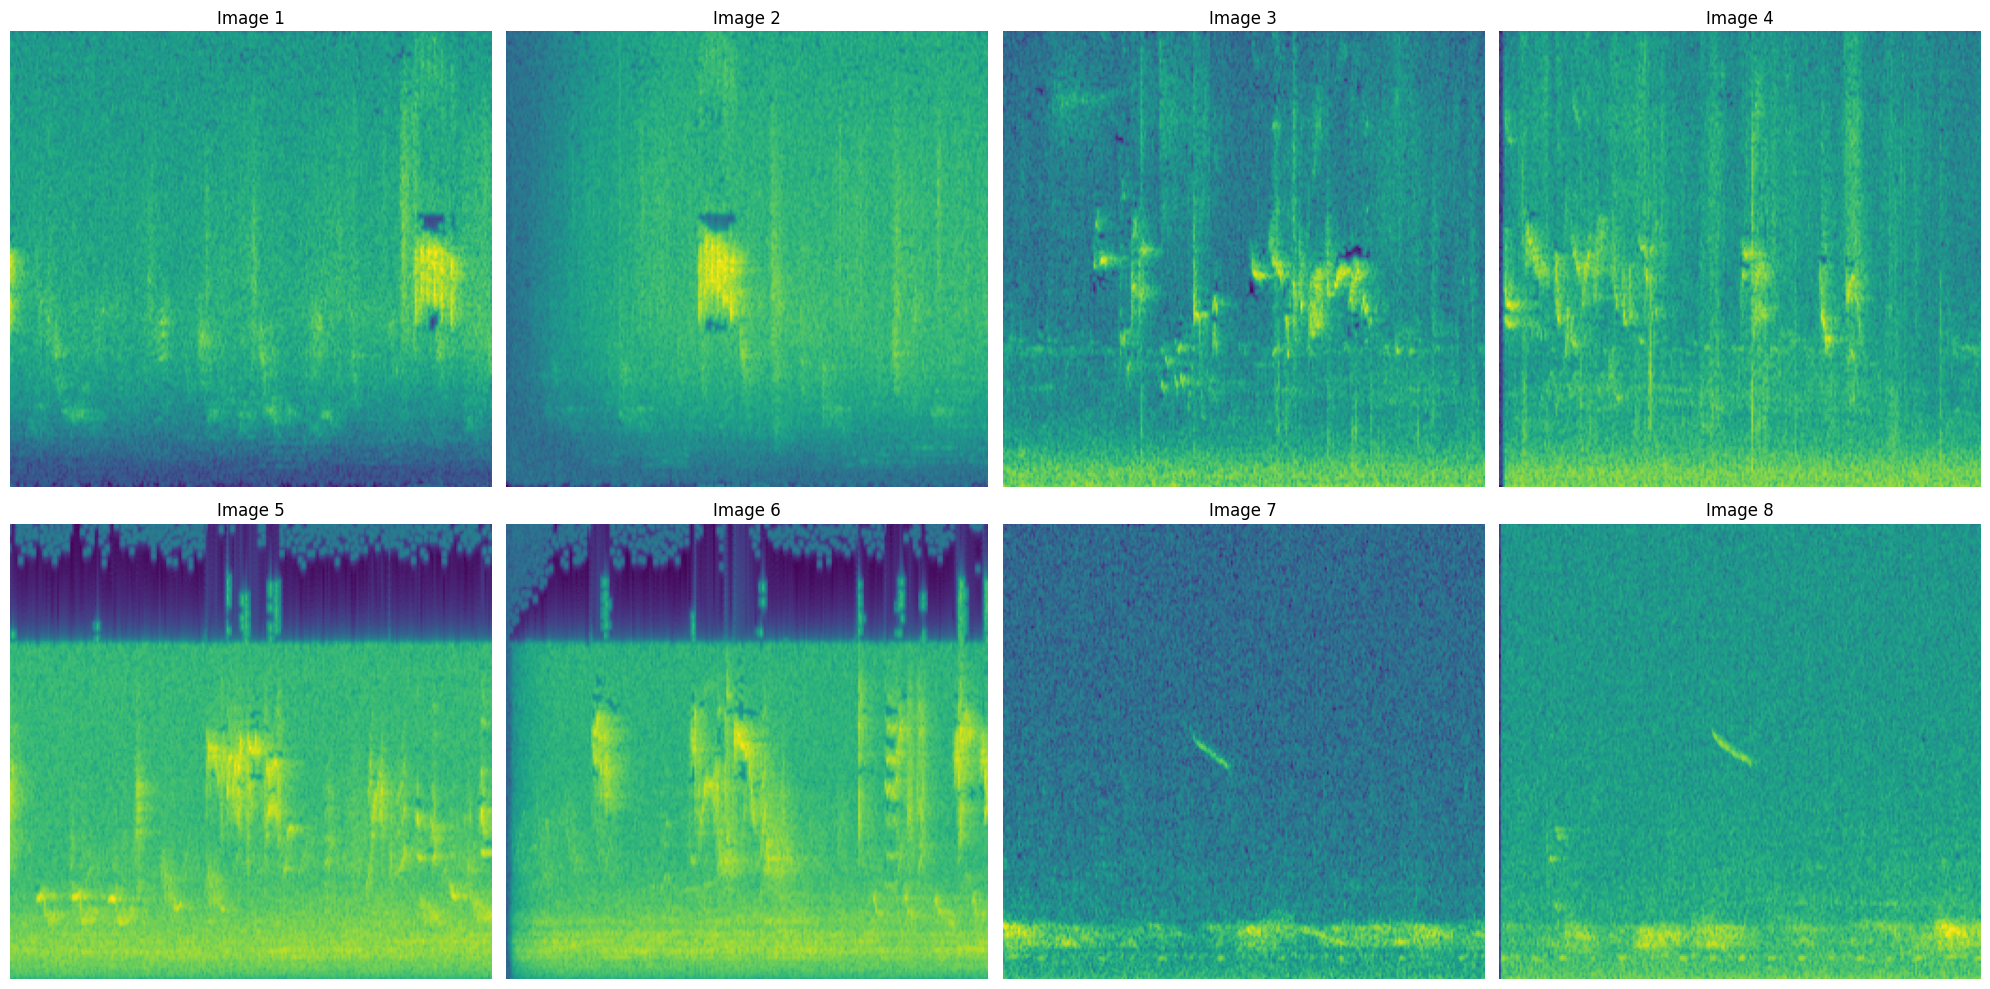

In [14]:
gene = TrainDataGenerator()
for x_batch, y_batch in (gene):
    print(x_batch.shape, y_batch.shape,)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, image in enumerate(x_batch[0:8]):
        ax = axs[i // 4, i % 4]
        ax.imshow(image, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    break

In [15]:
x, y = [], []

gene = TrainDataGenerator( batch_size= 32)

for i in tqdm(gene):
    x.append(i[0])
    y.append(i[1])
    
x = np.vstack(x)
y = np.vstack(y)

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 1/745 [00:02<25:15,  2.04s/it]

  0%|          | 2/745 [00:04<25:45,  2.08s/it]

  0%|          | 3/745 [00:06<25:36,  2.07s/it]

  1%|          | 4/745 [00:08<24:37,  1.99s/it]

  1%|          | 5/745 [00:10<26:50,  2.18s/it]

  1%|          | 6/745 [00:12<26:30,  2.15s/it]

  1%|          | 7/745 [00:14<25:42,  2.09s/it]

  1%|          | 8/745 [00:16<25:23,  2.07s/it]

  1%|          | 9/745 [00:18<23:59,  1.96s/it]

  1%|▏         | 10/745 [00:20<23:24,  1.91s/it]

  1%|▏         | 11/745 [00:22<23:26,  1.92s/it]

  2%|▏         | 12/745 [00:23<22:37,  1.85s/it]

  2%|▏         | 13/745 [00:25<23:35,  1.93s/it]

  2%|▏         | 14/745 [00:27<23:13,  1.91s/it]

  2%|▏         | 15/745 [00:30<25:22,  2.09s/it]

  2%|▏         | 16/745 [00:32<25:07,  2.07s/it]

  2%|▏         | 17/745 [00:34<24:17,  2.00s/it]

  2%|▏         | 18/745 [00:36<23:54,  1.97s/it]

  3%|▎         | 19/745 [00:37<22:47,  1.88s/it]

  3%|▎         | 20/745 [00:39<21:21,  1.77s/it]

  3%|▎         | 21/745 [00:41<21:33,  1.79s/it]

  3%|▎         | 22/745 [00:45<29:23,  2.44s/it]

  3%|▎         | 23/745 [00:47<27:48,  2.31s/it]

  3%|▎         | 24/745 [00:49<26:51,  2.24s/it]

  3%|▎         | 25/745 [00:51<27:44,  2.31s/it]

  3%|▎         | 26/745 [00:53<27:55,  2.33s/it]

  4%|▎         | 27/745 [00:56<27:52,  2.33s/it]

  4%|▍         | 28/745 [00:57<25:10,  2.11s/it]

  4%|▍         | 29/745 [00:59<24:05,  2.02s/it]

  4%|▍         | 30/745 [01:01<22:59,  1.93s/it]

  4%|▍         | 31/745 [01:03<23:31,  1.98s/it]

  4%|▍         | 32/745 [01:05<23:52,  2.01s/it]

  4%|▍         | 33/745 [01:07<24:29,  2.06s/it]

  5%|▍         | 34/745 [01:10<25:03,  2.11s/it]

  5%|▍         | 35/745 [01:11<24:32,  2.07s/it]

  5%|▍         | 36/745 [01:13<23:45,  2.01s/it]

  5%|▍         | 37/745 [01:16<25:55,  2.20s/it]

  5%|▌         | 38/745 [01:18<23:43,  2.01s/it]

  5%|▌         | 39/745 [01:19<22:29,  1.91s/it]

  5%|▌         | 40/745 [01:21<21:59,  1.87s/it]

  6%|▌         | 41/745 [01:23<21:40,  1.85s/it]

  6%|▌         | 42/745 [01:25<22:19,  1.91s/it]

  6%|▌         | 43/745 [01:27<21:42,  1.86s/it]

  6%|▌         | 44/745 [01:28<20:57,  1.79s/it]

  6%|▌         | 45/745 [01:30<22:23,  1.92s/it]

  6%|▌         | 46/745 [01:33<24:10,  2.08s/it]

  6%|▋         | 47/745 [01:35<22:37,  1.95s/it]

  6%|▋         | 48/745 [01:36<21:59,  1.89s/it]

  7%|▋         | 49/745 [01:38<21:48,  1.88s/it]

  7%|▋         | 50/745 [01:40<21:06,  1.82s/it]

  7%|▋         | 51/745 [01:42<23:01,  1.99s/it]

  7%|▋         | 52/745 [01:44<22:16,  1.93s/it]

  7%|▋         | 53/745 [01:46<21:46,  1.89s/it]

  7%|▋         | 54/745 [01:47<20:08,  1.75s/it]

  7%|▋         | 55/745 [01:49<21:33,  1.87s/it]

  8%|▊         | 56/745 [01:51<21:36,  1.88s/it]

  8%|▊         | 57/745 [01:53<21:11,  1.85s/it]

  8%|▊         | 58/745 [01:56<25:48,  2.25s/it]

  8%|▊         | 59/745 [01:59<26:13,  2.29s/it]

  8%|▊         | 60/745 [02:01<24:52,  2.18s/it]

  8%|▊         | 61/745 [02:03<24:16,  2.13s/it]

  8%|▊         | 62/745 [02:06<29:08,  2.56s/it]

  8%|▊         | 63/745 [02:08<26:49,  2.36s/it]

  9%|▊         | 64/745 [02:10<25:04,  2.21s/it]

  9%|▊         | 65/745 [02:12<24:49,  2.19s/it]

  9%|▉         | 66/745 [02:14<22:56,  2.03s/it]

  9%|▉         | 67/745 [02:15<22:05,  1.96s/it]

  9%|▉         | 68/745 [02:17<22:18,  1.98s/it]

  9%|▉         | 69/745 [02:19<21:11,  1.88s/it]

  9%|▉         | 70/745 [02:21<22:02,  1.96s/it]

 10%|▉         | 71/745 [02:23<22:33,  2.01s/it]

 10%|▉         | 72/745 [02:25<22:24,  2.00s/it]

 10%|▉         | 73/745 [02:27<21:02,  1.88s/it]

 10%|▉         | 74/745 [02:29<22:59,  2.06s/it]

 10%|█         | 75/745 [02:31<22:51,  2.05s/it]

 10%|█         | 76/745 [02:34<23:29,  2.11s/it]

 10%|█         | 77/745 [02:36<24:12,  2.18s/it]

 10%|█         | 78/745 [02:38<23:27,  2.11s/it]

 11%|█         | 79/745 [02:40<22:57,  2.07s/it]

 11%|█         | 80/745 [02:42<22:04,  1.99s/it]

 11%|█         | 81/745 [02:44<23:05,  2.09s/it]

 11%|█         | 82/745 [02:46<22:03,  2.00s/it]

 11%|█         | 83/745 [02:49<24:51,  2.25s/it]

 11%|█▏        | 84/745 [02:50<22:13,  2.02s/it]

 11%|█▏        | 85/745 [02:53<23:39,  2.15s/it]

 12%|█▏        | 86/745 [02:54<21:42,  1.98s/it]

 12%|█▏        | 87/745 [02:56<20:55,  1.91s/it]

 12%|█▏        | 88/745 [02:58<21:04,  1.92s/it]

 12%|█▏        | 89/745 [03:00<21:23,  1.96s/it]

 12%|█▏        | 90/745 [03:02<21:38,  1.98s/it]

 12%|█▏        | 91/745 [03:04<20:30,  1.88s/it]

 12%|█▏        | 92/745 [03:05<19:49,  1.82s/it]

 12%|█▏        | 93/745 [03:07<19:04,  1.76s/it]

 13%|█▎        | 94/745 [03:09<19:50,  1.83s/it]

 13%|█▎        | 95/745 [03:11<19:48,  1.83s/it]

 13%|█▎        | 96/745 [03:15<27:06,  2.51s/it]

 13%|█▎        | 97/745 [03:18<29:00,  2.69s/it]

 13%|█▎        | 98/745 [03:23<35:33,  3.30s/it]

 13%|█▎        | 99/745 [03:29<46:17,  4.30s/it]

 13%|█▎        | 100/745 [03:34<46:26,  4.32s/it]

 14%|█▎        | 101/745 [03:38<46:34,  4.34s/it]

 14%|█▎        | 102/745 [03:46<56:36,  5.28s/it]

 14%|█▍        | 103/745 [03:51<56:57,  5.32s/it]

 14%|█▍        | 104/745 [04:00<1:07:50,  6.35s/it]

 14%|█▍        | 105/745 [04:03<56:46,  5.32s/it]  

 14%|█▍        | 106/745 [04:08<55:39,  5.23s/it]

 14%|█▍        | 107/745 [04:11<49:33,  4.66s/it]

 14%|█▍        | 108/745 [04:17<52:24,  4.94s/it]

 15%|█▍        | 109/745 [04:24<1:00:04,  5.67s/it]

 15%|█▍        | 110/745 [04:32<1:07:04,  6.34s/it]

 15%|█▍        | 111/745 [04:56<2:04:39, 11.80s/it]

 15%|█▌        | 112/745 [04:58<1:32:09,  8.74s/it]

 15%|█▌        | 113/745 [05:00<1:09:33,  6.60s/it]

 15%|█▌        | 114/745 [05:02<56:19,  5.36s/it]  

 15%|█▌        | 115/745 [05:04<45:07,  4.30s/it]

 16%|█▌        | 116/745 [05:06<39:24,  3.76s/it]

 16%|█▌        | 117/745 [05:08<33:54,  3.24s/it]

 16%|█▌        | 118/745 [05:10<29:49,  2.85s/it]

 16%|█▌        | 119/745 [05:13<27:50,  2.67s/it]

 16%|█▌        | 120/745 [05:15<26:00,  2.50s/it]

 16%|█▌        | 121/745 [05:17<24:43,  2.38s/it]

 16%|█▋        | 122/745 [05:18<22:14,  2.14s/it]

 17%|█▋        | 123/745 [05:20<21:26,  2.07s/it]

 17%|█▋        | 124/745 [05:23<22:50,  2.21s/it]

 17%|█▋        | 125/745 [05:25<21:58,  2.13s/it]

 17%|█▋        | 126/745 [05:27<21:14,  2.06s/it]

 17%|█▋        | 127/745 [05:29<23:32,  2.29s/it]

 17%|█▋        | 128/745 [05:31<22:26,  2.18s/it]

 17%|█▋        | 129/745 [05:34<22:52,  2.23s/it]

 17%|█▋        | 130/745 [05:36<23:48,  2.32s/it]

 18%|█▊        | 131/745 [05:38<22:49,  2.23s/it]

 18%|█▊        | 132/745 [05:40<22:10,  2.17s/it]

 18%|█▊        | 133/745 [05:42<21:07,  2.07s/it]

 18%|█▊        | 134/745 [05:44<20:37,  2.02s/it]

 18%|█▊        | 135/745 [05:47<23:50,  2.34s/it]

 18%|█▊        | 136/745 [05:49<22:33,  2.22s/it]

 18%|█▊        | 137/745 [05:51<21:15,  2.10s/it]

 19%|█▊        | 138/745 [05:53<19:59,  1.98s/it]

 19%|█▊        | 139/745 [05:54<19:26,  1.93s/it]

 19%|█▉        | 140/745 [05:57<22:39,  2.25s/it]

 19%|█▉        | 141/745 [05:59<21:11,  2.11s/it]

 19%|█▉        | 142/745 [06:02<23:51,  2.37s/it]

 19%|█▉        | 143/745 [06:04<21:19,  2.12s/it]

 19%|█▉        | 144/745 [06:05<19:39,  1.96s/it]

 19%|█▉        | 145/745 [06:07<18:29,  1.85s/it]

 20%|█▉        | 146/745 [06:09<17:36,  1.76s/it]

 20%|█▉        | 147/745 [06:11<18:39,  1.87s/it]

 20%|█▉        | 148/745 [06:12<16:58,  1.71s/it]

 20%|██        | 149/745 [06:13<16:14,  1.64s/it]

 20%|██        | 150/745 [06:15<15:54,  1.60s/it]

 20%|██        | 151/745 [06:17<15:48,  1.60s/it]

 20%|██        | 152/745 [06:19<17:20,  1.75s/it]

 21%|██        | 153/745 [06:20<16:28,  1.67s/it]

 21%|██        | 154/745 [06:22<16:36,  1.69s/it]

 21%|██        | 155/745 [06:24<17:23,  1.77s/it]

 21%|██        | 156/745 [06:25<16:11,  1.65s/it]

 21%|██        | 157/745 [06:27<15:38,  1.60s/it]

 21%|██        | 158/745 [06:29<17:05,  1.75s/it]

 21%|██▏       | 159/745 [06:30<16:34,  1.70s/it]

 21%|██▏       | 160/745 [06:32<17:05,  1.75s/it]

 22%|██▏       | 161/745 [06:34<17:02,  1.75s/it]

 22%|██▏       | 162/745 [06:36<17:04,  1.76s/it]

 22%|██▏       | 163/745 [06:38<17:50,  1.84s/it]

 22%|██▏       | 164/745 [06:40<18:44,  1.94s/it]

 22%|██▏       | 165/745 [06:42<19:19,  2.00s/it]

 22%|██▏       | 166/745 [06:44<19:19,  2.00s/it]

 22%|██▏       | 167/745 [06:46<19:03,  1.98s/it]

 23%|██▎       | 168/745 [06:48<18:51,  1.96s/it]

 23%|██▎       | 169/745 [06:50<19:42,  2.05s/it]

 23%|██▎       | 170/745 [06:53<20:26,  2.13s/it]

 23%|██▎       | 171/745 [06:54<18:20,  1.92s/it]

 23%|██▎       | 172/745 [06:56<17:28,  1.83s/it]

 23%|██▎       | 173/745 [06:58<18:37,  1.95s/it]

 23%|██▎       | 174/745 [07:01<20:52,  2.19s/it]

 23%|██▎       | 175/745 [07:02<18:58,  2.00s/it]

 24%|██▎       | 176/745 [07:04<17:34,  1.85s/it]

 24%|██▍       | 177/745 [07:05<16:49,  1.78s/it]

 24%|██▍       | 178/745 [07:07<15:39,  1.66s/it]

 24%|██▍       | 179/745 [07:08<15:24,  1.63s/it]

 24%|██▍       | 180/745 [07:09<14:26,  1.53s/it]

 24%|██▍       | 181/745 [07:11<14:30,  1.54s/it]

 24%|██▍       | 182/745 [07:12<13:45,  1.47s/it]

 25%|██▍       | 183/745 [07:14<13:59,  1.49s/it]

 25%|██▍       | 184/745 [07:16<17:08,  1.83s/it]

 25%|██▍       | 185/745 [07:18<16:00,  1.71s/it]

 25%|██▍       | 186/745 [07:19<15:04,  1.62s/it]

 25%|██▌       | 187/745 [07:21<13:56,  1.50s/it]

 25%|██▌       | 188/745 [07:22<13:37,  1.47s/it]

 25%|██▌       | 189/745 [07:24<13:58,  1.51s/it]

 26%|██▌       | 190/745 [07:25<13:16,  1.44s/it]

 26%|██▌       | 191/745 [07:26<12:48,  1.39s/it]

 26%|██▌       | 192/745 [07:27<12:27,  1.35s/it]

 26%|██▌       | 193/745 [07:29<12:22,  1.34s/it]

 26%|██▌       | 194/745 [07:30<12:07,  1.32s/it]

 26%|██▌       | 195/745 [07:32<13:57,  1.52s/it]

 26%|██▋       | 196/745 [07:34<14:21,  1.57s/it]

 26%|██▋       | 197/745 [07:35<13:58,  1.53s/it]

 27%|██▋       | 198/745 [07:37<14:23,  1.58s/it]

 27%|██▋       | 199/745 [07:39<16:16,  1.79s/it]

 27%|██▋       | 200/745 [07:41<17:18,  1.91s/it]

 27%|██▋       | 201/745 [07:43<17:58,  1.98s/it]

 27%|██▋       | 202/745 [08:02<1:03:03,  6.97s/it]

 27%|██▋       | 203/745 [08:06<56:20,  6.24s/it]  

 27%|██▋       | 204/745 [08:09<45:00,  4.99s/it]

 28%|██▊       | 205/745 [08:10<35:29,  3.94s/it]

 28%|██▊       | 206/745 [08:12<28:48,  3.21s/it]

 28%|██▊       | 207/745 [08:13<25:12,  2.81s/it]

 28%|██▊       | 208/745 [08:15<22:58,  2.57s/it]

 28%|██▊       | 209/745 [08:18<22:03,  2.47s/it]

 28%|██▊       | 210/745 [08:20<22:26,  2.52s/it]

 28%|██▊       | 211/745 [08:23<22:48,  2.56s/it]

 28%|██▊       | 212/745 [08:25<22:05,  2.49s/it]

 29%|██▊       | 213/745 [08:27<21:08,  2.38s/it]

 29%|██▊       | 214/745 [08:30<20:39,  2.33s/it]

 29%|██▉       | 215/745 [08:32<19:31,  2.21s/it]

 29%|██▉       | 216/745 [08:34<19:58,  2.27s/it]

 29%|██▉       | 217/745 [08:37<22:05,  2.51s/it]

 29%|██▉       | 218/745 [08:40<22:54,  2.61s/it]

 29%|██▉       | 219/745 [08:43<23:02,  2.63s/it]

 30%|██▉       | 220/745 [08:45<21:47,  2.49s/it]

 30%|██▉       | 221/745 [08:47<22:06,  2.53s/it]

 30%|██▉       | 222/745 [08:49<20:01,  2.30s/it]

 30%|██▉       | 223/745 [08:51<18:56,  2.18s/it]

 30%|███       | 224/745 [08:53<17:14,  1.99s/it]

 30%|███       | 225/745 [08:54<16:14,  1.87s/it]

 30%|███       | 226/745 [08:56<15:28,  1.79s/it]

 30%|███       | 227/745 [08:57<13:45,  1.59s/it]

 31%|███       | 228/745 [08:59<13:52,  1.61s/it]

 31%|███       | 229/745 [09:01<14:49,  1.72s/it]

 31%|███       | 230/745 [09:02<13:52,  1.62s/it]

 31%|███       | 231/745 [09:04<14:54,  1.74s/it]

 31%|███       | 232/745 [09:05<13:56,  1.63s/it]

 31%|███▏      | 233/745 [09:07<13:43,  1.61s/it]

 31%|███▏      | 234/745 [09:09<13:54,  1.63s/it]

 32%|███▏      | 235/745 [09:10<13:23,  1.58s/it]

 32%|███▏      | 236/745 [09:12<14:08,  1.67s/it]

 32%|███▏      | 237/745 [09:13<13:20,  1.58s/it]

 32%|███▏      | 238/745 [09:15<13:45,  1.63s/it]

 32%|███▏      | 239/745 [09:17<14:01,  1.66s/it]

 32%|███▏      | 240/745 [09:18<13:36,  1.62s/it]

 32%|███▏      | 241/745 [09:20<14:33,  1.73s/it]

 32%|███▏      | 242/745 [09:22<14:12,  1.70s/it]

 33%|███▎      | 243/745 [09:24<14:15,  1.70s/it]

 33%|███▎      | 244/745 [09:25<14:42,  1.76s/it]

 33%|███▎      | 245/745 [09:27<14:43,  1.77s/it]

 33%|███▎      | 246/745 [09:30<16:14,  1.95s/it]

 33%|███▎      | 247/745 [09:31<15:22,  1.85s/it]

 33%|███▎      | 248/745 [09:33<15:00,  1.81s/it]

 33%|███▎      | 249/745 [09:35<14:52,  1.80s/it]

 34%|███▎      | 250/745 [09:37<15:09,  1.84s/it]

 34%|███▎      | 251/745 [09:39<15:22,  1.87s/it]

 34%|███▍      | 252/745 [09:42<18:04,  2.20s/it]

 34%|███▍      | 253/745 [09:43<17:01,  2.08s/it]

 34%|███▍      | 254/745 [09:45<16:51,  2.06s/it]

 34%|███▍      | 255/745 [09:47<15:55,  1.95s/it]

 34%|███▍      | 256/745 [09:49<15:27,  1.90s/it]

 34%|███▍      | 257/745 [09:51<15:29,  1.91s/it]

 35%|███▍      | 258/745 [09:52<14:32,  1.79s/it]

 35%|███▍      | 259/745 [09:54<14:38,  1.81s/it]

 35%|███▍      | 260/745 [09:56<15:14,  1.89s/it]

 35%|███▌      | 261/745 [09:58<14:50,  1.84s/it]

 35%|███▌      | 262/745 [10:00<14:52,  1.85s/it]

 35%|███▌      | 263/745 [10:02<14:51,  1.85s/it]

 35%|███▌      | 264/745 [10:03<14:25,  1.80s/it]

 36%|███▌      | 265/745 [10:05<13:28,  1.68s/it]

 36%|███▌      | 266/745 [10:07<14:03,  1.76s/it]

 36%|███▌      | 267/745 [10:08<13:50,  1.74s/it]

 36%|███▌      | 268/745 [10:10<13:34,  1.71s/it]

 36%|███▌      | 269/745 [10:12<13:44,  1.73s/it]

 36%|███▌      | 270/745 [10:14<14:13,  1.80s/it]

 36%|███▋      | 271/745 [10:16<14:12,  1.80s/it]

 37%|███▋      | 272/745 [10:17<13:26,  1.70s/it]

 37%|███▋      | 273/745 [10:19<13:44,  1.75s/it]

 37%|███▋      | 274/745 [10:21<14:12,  1.81s/it]

 37%|███▋      | 275/745 [10:23<14:36,  1.86s/it]

 37%|███▋      | 276/745 [10:26<17:16,  2.21s/it]

 37%|███▋      | 277/745 [10:29<19:45,  2.53s/it]

 37%|███▋      | 278/745 [10:31<18:08,  2.33s/it]

 37%|███▋      | 279/745 [10:33<17:10,  2.21s/it]

 38%|███▊      | 280/745 [10:35<16:02,  2.07s/it]

 38%|███▊      | 281/745 [10:36<14:46,  1.91s/it]

 38%|███▊      | 282/745 [10:38<13:44,  1.78s/it]

 38%|███▊      | 283/745 [10:39<13:14,  1.72s/it]

 38%|███▊      | 284/745 [10:41<13:19,  1.73s/it]

 38%|███▊      | 285/745 [10:45<19:14,  2.51s/it]

 38%|███▊      | 286/745 [10:47<17:41,  2.31s/it]

 39%|███▊      | 287/745 [10:50<17:47,  2.33s/it]

 39%|███▊      | 288/745 [10:51<16:39,  2.19s/it]

 39%|███▉      | 289/745 [10:53<15:46,  2.08s/it]

 39%|███▉      | 290/745 [10:55<15:33,  2.05s/it]

 39%|███▉      | 291/745 [10:57<15:20,  2.03s/it]

 39%|███▉      | 292/745 [10:59<15:22,  2.04s/it]

 39%|███▉      | 293/745 [11:01<14:16,  1.90s/it]

 39%|███▉      | 294/745 [11:03<14:00,  1.86s/it]

 40%|███▉      | 295/745 [11:04<13:30,  1.80s/it]

 40%|███▉      | 296/745 [11:06<12:13,  1.63s/it]

 40%|███▉      | 297/745 [11:07<11:43,  1.57s/it]

 40%|████      | 298/745 [11:09<12:56,  1.74s/it]

 40%|████      | 299/745 [11:11<12:11,  1.64s/it]

 40%|████      | 300/745 [11:12<12:24,  1.67s/it]

 40%|████      | 301/745 [11:14<11:43,  1.58s/it]

 41%|████      | 302/745 [11:15<12:14,  1.66s/it]

 41%|████      | 303/745 [11:17<11:26,  1.55s/it]

 41%|████      | 304/745 [11:19<11:52,  1.61s/it]

 41%|████      | 305/745 [11:20<11:42,  1.60s/it]

 41%|████      | 306/745 [11:22<11:33,  1.58s/it]

 41%|████      | 307/745 [11:24<12:39,  1.73s/it]

 41%|████▏     | 308/745 [11:26<12:46,  1.75s/it]

 41%|████▏     | 309/745 [11:27<12:25,  1.71s/it]

 42%|████▏     | 310/745 [11:29<11:51,  1.64s/it]

 42%|████▏     | 311/745 [11:30<10:55,  1.51s/it]

 42%|████▏     | 312/745 [11:31<10:51,  1.51s/it]

 42%|████▏     | 313/745 [11:33<10:46,  1.50s/it]

 42%|████▏     | 314/745 [11:34<10:43,  1.49s/it]

 42%|████▏     | 315/745 [11:36<10:28,  1.46s/it]

 42%|████▏     | 316/745 [11:38<11:18,  1.58s/it]

 43%|████▎     | 317/745 [11:40<12:35,  1.77s/it]

 43%|████▎     | 318/745 [11:43<15:08,  2.13s/it]

 43%|████▎     | 319/745 [11:46<16:37,  2.34s/it]

 43%|████▎     | 320/745 [11:48<15:56,  2.25s/it]

 43%|████▎     | 321/745 [11:49<15:09,  2.14s/it]

 43%|████▎     | 322/745 [11:52<15:05,  2.14s/it]

 43%|████▎     | 323/745 [11:54<15:42,  2.23s/it]

 43%|████▎     | 324/745 [11:56<14:12,  2.02s/it]

 44%|████▎     | 325/745 [11:57<12:51,  1.84s/it]

 44%|████▍     | 326/745 [11:59<12:33,  1.80s/it]

 44%|████▍     | 327/745 [12:00<12:09,  1.74s/it]

 44%|████▍     | 328/745 [12:02<12:05,  1.74s/it]

 44%|████▍     | 329/745 [12:03<11:18,  1.63s/it]

 44%|████▍     | 330/745 [12:06<13:28,  1.95s/it]

 44%|████▍     | 331/745 [12:08<13:23,  1.94s/it]

 45%|████▍     | 332/745 [12:09<12:05,  1.76s/it]

 45%|████▍     | 333/745 [12:11<11:26,  1.67s/it]

 45%|████▍     | 334/745 [12:12<11:21,  1.66s/it]

 45%|████▍     | 335/745 [12:14<11:53,  1.74s/it]

 45%|████▌     | 336/745 [12:16<11:20,  1.66s/it]

 45%|████▌     | 337/745 [12:18<11:20,  1.67s/it]

 45%|████▌     | 338/745 [12:20<12:10,  1.80s/it]

 46%|████▌     | 339/745 [12:21<11:53,  1.76s/it]

 46%|████▌     | 340/745 [12:23<12:09,  1.80s/it]

 46%|████▌     | 341/745 [12:25<11:26,  1.70s/it]

 46%|████▌     | 342/745 [12:26<10:19,  1.54s/it]

 46%|████▌     | 343/745 [12:27<09:47,  1.46s/it]

 46%|████▌     | 344/745 [12:29<11:13,  1.68s/it]

 46%|████▋     | 345/745 [12:30<09:46,  1.47s/it]

 46%|████▋     | 346/745 [12:32<09:19,  1.40s/it]

 47%|████▋     | 347/745 [12:33<08:53,  1.34s/it]

 47%|████▋     | 348/745 [12:34<09:16,  1.40s/it]

 47%|████▋     | 349/745 [12:36<09:36,  1.45s/it]

 47%|████▋     | 350/745 [12:38<10:59,  1.67s/it]

 47%|████▋     | 351/745 [12:40<11:46,  1.79s/it]

 47%|████▋     | 352/745 [12:42<12:09,  1.86s/it]

 47%|████▋     | 353/745 [12:44<11:39,  1.78s/it]

 48%|████▊     | 354/745 [12:47<14:22,  2.21s/it]

 48%|████▊     | 355/745 [12:49<14:48,  2.28s/it]

 48%|████▊     | 356/745 [12:52<15:01,  2.32s/it]

 48%|████▊     | 357/745 [12:54<15:21,  2.37s/it]

 48%|████▊     | 358/745 [12:56<14:06,  2.19s/it]

 48%|████▊     | 359/745 [12:58<14:31,  2.26s/it]

 48%|████▊     | 360/745 [13:01<14:49,  2.31s/it]

 48%|████▊     | 361/745 [13:03<14:30,  2.27s/it]

 49%|████▊     | 362/745 [13:05<13:13,  2.07s/it]

 49%|████▊     | 363/745 [13:07<14:14,  2.24s/it]

 49%|████▉     | 364/745 [13:11<17:36,  2.77s/it]

 49%|████▉     | 365/745 [13:16<20:56,  3.31s/it]

 49%|████▉     | 366/745 [13:18<18:58,  3.00s/it]

 49%|████▉     | 367/745 [13:22<20:44,  3.29s/it]

 49%|████▉     | 368/745 [13:25<20:30,  3.26s/it]

 50%|████▉     | 369/745 [13:27<17:48,  2.84s/it]

 50%|████▉     | 370/745 [13:29<15:41,  2.51s/it]

 50%|████▉     | 371/745 [13:30<13:18,  2.13s/it]

 50%|████▉     | 372/745 [13:32<12:52,  2.07s/it]

 50%|█████     | 373/745 [13:33<11:26,  1.85s/it]

 50%|█████     | 374/745 [13:35<10:51,  1.76s/it]

 50%|█████     | 375/745 [13:37<10:54,  1.77s/it]

 50%|█████     | 376/745 [13:38<10:26,  1.70s/it]

 51%|█████     | 377/745 [13:40<09:58,  1.63s/it]

 51%|█████     | 378/745 [13:41<09:31,  1.56s/it]

 51%|█████     | 379/745 [13:43<09:27,  1.55s/it]

 51%|█████     | 380/745 [13:44<09:37,  1.58s/it]

 51%|█████     | 381/745 [13:46<09:28,  1.56s/it]

 51%|█████▏    | 382/745 [13:47<09:13,  1.52s/it]

 51%|█████▏    | 383/745 [13:49<09:31,  1.58s/it]

 52%|█████▏    | 384/745 [13:51<10:55,  1.81s/it]

 52%|█████▏    | 385/745 [13:53<10:53,  1.82s/it]

 52%|█████▏    | 386/745 [13:56<12:04,  2.02s/it]

 52%|█████▏    | 387/745 [13:58<12:36,  2.11s/it]

 52%|█████▏    | 388/745 [14:00<12:16,  2.06s/it]

 52%|█████▏    | 389/745 [14:02<12:26,  2.10s/it]

 52%|█████▏    | 390/745 [14:04<11:32,  1.95s/it]

 52%|█████▏    | 391/745 [14:06<12:00,  2.04s/it]

 53%|█████▎    | 392/745 [14:08<12:39,  2.15s/it]

 53%|█████▎    | 393/745 [14:11<12:59,  2.22s/it]

 53%|█████▎    | 394/745 [14:13<13:20,  2.28s/it]

 53%|█████▎    | 395/745 [14:15<12:25,  2.13s/it]

 53%|█████▎    | 396/745 [14:17<11:56,  2.05s/it]

 53%|█████▎    | 397/745 [14:18<10:40,  1.84s/it]

 53%|█████▎    | 398/745 [14:20<10:22,  1.79s/it]

 54%|█████▎    | 399/745 [14:22<10:13,  1.77s/it]

 54%|█████▎    | 400/745 [14:24<10:48,  1.88s/it]

 54%|█████▍    | 401/745 [14:26<11:06,  1.94s/it]

 54%|█████▍    | 402/745 [14:28<11:31,  2.02s/it]

 54%|█████▍    | 403/745 [14:30<11:00,  1.93s/it]

 54%|█████▍    | 404/745 [14:31<10:25,  1.83s/it]

 54%|█████▍    | 405/745 [14:33<10:37,  1.87s/it]

 54%|█████▍    | 406/745 [14:35<10:17,  1.82s/it]

 55%|█████▍    | 407/745 [14:36<09:31,  1.69s/it]

 55%|█████▍    | 408/745 [14:38<09:25,  1.68s/it]

 55%|█████▍    | 409/745 [14:40<09:05,  1.62s/it]

 55%|█████▌    | 410/745 [14:41<09:28,  1.70s/it]

 55%|█████▌    | 411/745 [14:43<08:53,  1.60s/it]

 55%|█████▌    | 412/745 [14:44<08:51,  1.60s/it]

 55%|█████▌    | 413/745 [14:47<09:45,  1.76s/it]

 56%|█████▌    | 414/745 [14:48<09:23,  1.70s/it]

 56%|█████▌    | 415/745 [14:50<09:24,  1.71s/it]

 56%|█████▌    | 416/745 [14:52<09:44,  1.78s/it]

 56%|█████▌    | 417/745 [14:54<10:23,  1.90s/it]

 56%|█████▌    | 418/745 [14:56<09:53,  1.81s/it]

 56%|█████▌    | 419/745 [14:58<11:33,  2.13s/it]

 56%|█████▋    | 420/745 [15:00<11:12,  2.07s/it]

 57%|█████▋    | 421/745 [15:02<10:54,  2.02s/it]

 57%|█████▋    | 422/745 [15:04<10:25,  1.94s/it]

 57%|█████▋    | 423/745 [15:06<10:46,  2.01s/it]

 57%|█████▋    | 424/745 [15:08<11:09,  2.08s/it]

 57%|█████▋    | 425/745 [15:10<10:42,  2.01s/it]

 57%|█████▋    | 426/745 [15:12<10:26,  1.96s/it]

 57%|█████▋    | 427/745 [15:14<10:30,  1.98s/it]

 57%|█████▋    | 428/745 [15:16<10:53,  2.06s/it]

 58%|█████▊    | 429/745 [15:21<14:08,  2.69s/it]

 58%|█████▊    | 430/745 [15:23<14:01,  2.67s/it]

 58%|█████▊    | 431/745 [15:25<12:58,  2.48s/it]

 58%|█████▊    | 432/745 [15:27<12:22,  2.37s/it]

 58%|█████▊    | 433/745 [15:29<11:44,  2.26s/it]

 58%|█████▊    | 434/745 [15:33<13:52,  2.68s/it]

 58%|█████▊    | 435/745 [15:36<14:25,  2.79s/it]

 59%|█████▊    | 436/745 [15:38<13:39,  2.65s/it]

 59%|█████▊    | 437/745 [15:41<13:37,  2.66s/it]

 59%|█████▉    | 438/745 [15:43<12:54,  2.52s/it]

 59%|█████▉    | 439/745 [15:46<13:06,  2.57s/it]

 59%|█████▉    | 440/745 [15:48<11:57,  2.35s/it]

 59%|█████▉    | 441/745 [15:49<10:59,  2.17s/it]

 59%|█████▉    | 442/745 [15:51<10:29,  2.08s/it]

 59%|█████▉    | 443/745 [15:53<09:46,  1.94s/it]

 60%|█████▉    | 444/745 [15:55<09:41,  1.93s/it]

 60%|█████▉    | 445/745 [15:57<09:51,  1.97s/it]

 60%|█████▉    | 446/745 [15:59<10:12,  2.05s/it]

 60%|██████    | 447/745 [16:02<11:14,  2.26s/it]

 60%|██████    | 448/745 [16:05<12:05,  2.44s/it]

 60%|██████    | 449/745 [16:16<25:04,  5.08s/it]

 60%|██████    | 450/745 [16:19<21:55,  4.46s/it]

 61%|██████    | 451/745 [16:22<19:25,  3.96s/it]

 61%|██████    | 452/745 [16:24<16:31,  3.38s/it]

 61%|██████    | 453/745 [16:26<14:29,  2.98s/it]

 61%|██████    | 454/745 [16:28<13:37,  2.81s/it]

 61%|██████    | 455/745 [16:31<13:20,  2.76s/it]

 61%|██████    | 456/745 [16:34<14:22,  2.98s/it]

 61%|██████▏   | 457/745 [16:37<13:21,  2.78s/it]

 61%|██████▏   | 458/745 [16:39<13:06,  2.74s/it]

 62%|██████▏   | 459/745 [16:46<18:56,  3.97s/it]

 62%|██████▏   | 460/745 [16:49<16:49,  3.54s/it]

 62%|██████▏   | 461/745 [16:52<16:02,  3.39s/it]

 62%|██████▏   | 462/745 [16:54<13:56,  2.95s/it]

 62%|██████▏   | 463/745 [16:56<12:31,  2.66s/it]

 62%|██████▏   | 464/745 [16:57<10:54,  2.33s/it]

 62%|██████▏   | 465/745 [16:59<10:13,  2.19s/it]

 63%|██████▎   | 466/745 [17:01<09:22,  2.02s/it]

 63%|██████▎   | 467/745 [17:03<09:33,  2.06s/it]

 63%|██████▎   | 468/745 [17:05<09:14,  2.00s/it]

 63%|██████▎   | 469/745 [17:07<09:04,  1.97s/it]

 63%|██████▎   | 470/745 [17:09<09:29,  2.07s/it]

 63%|██████▎   | 471/745 [17:11<08:56,  1.96s/it]

 63%|██████▎   | 472/745 [17:13<08:42,  1.91s/it]

 63%|██████▎   | 473/745 [17:14<08:31,  1.88s/it]

 64%|██████▎   | 474/745 [17:16<08:36,  1.90s/it]

 64%|██████▍   | 475/745 [17:19<09:20,  2.08s/it]

 64%|██████▍   | 476/745 [17:21<08:58,  2.00s/it]

 64%|██████▍   | 477/745 [17:23<08:48,  1.97s/it]

 64%|██████▍   | 478/745 [17:24<07:45,  1.74s/it]

 64%|██████▍   | 479/745 [17:25<07:15,  1.64s/it]

 64%|██████▍   | 480/745 [17:26<06:41,  1.51s/it]

 65%|██████▍   | 481/745 [17:28<06:34,  1.49s/it]

 65%|██████▍   | 482/745 [17:29<06:09,  1.40s/it]

 65%|██████▍   | 483/745 [17:30<05:55,  1.36s/it]

 65%|██████▍   | 484/745 [17:32<06:12,  1.43s/it]

 65%|██████▌   | 485/745 [17:33<06:20,  1.46s/it]

 65%|██████▌   | 486/745 [17:35<07:03,  1.64s/it]

 65%|██████▌   | 487/745 [17:37<07:01,  1.63s/it]

 66%|██████▌   | 488/745 [17:39<07:40,  1.79s/it]

 66%|██████▌   | 489/745 [17:41<07:35,  1.78s/it]

 66%|██████▌   | 490/745 [17:43<07:41,  1.81s/it]

 66%|██████▌   | 491/745 [17:45<07:41,  1.82s/it]

 66%|██████▌   | 492/745 [17:47<08:32,  2.02s/it]

 66%|██████▌   | 493/745 [17:49<08:19,  1.98s/it]

 66%|██████▋   | 494/745 [17:51<08:30,  2.03s/it]

 66%|██████▋   | 495/745 [17:53<08:13,  1.97s/it]

 67%|██████▋   | 496/745 [17:55<07:52,  1.90s/it]

 67%|██████▋   | 497/745 [17:57<07:57,  1.93s/it]

 67%|██████▋   | 498/745 [17:58<07:38,  1.86s/it]

 67%|██████▋   | 499/745 [18:01<08:10,  1.99s/it]

 67%|██████▋   | 500/745 [18:02<07:46,  1.90s/it]

 67%|██████▋   | 501/745 [18:05<08:36,  2.12s/it]

 67%|██████▋   | 502/745 [18:07<07:55,  1.96s/it]

 68%|██████▊   | 503/745 [18:10<09:10,  2.28s/it]

 68%|██████▊   | 504/745 [18:12<08:40,  2.16s/it]

 68%|██████▊   | 505/745 [18:13<07:56,  1.98s/it]

 68%|██████▊   | 506/745 [18:14<07:07,  1.79s/it]

 68%|██████▊   | 507/745 [18:16<06:43,  1.70s/it]

 68%|██████▊   | 508/745 [18:18<06:47,  1.72s/it]

 68%|██████▊   | 509/745 [18:19<06:32,  1.66s/it]

 68%|██████▊   | 510/745 [18:21<06:17,  1.61s/it]

 69%|██████▊   | 511/745 [18:23<06:29,  1.66s/it]

 69%|██████▊   | 512/745 [18:24<06:18,  1.63s/it]

 69%|██████▉   | 513/745 [18:26<07:03,  1.83s/it]

 69%|██████▉   | 514/745 [18:28<07:17,  1.89s/it]

 69%|██████▉   | 515/745 [18:30<06:53,  1.80s/it]

 69%|██████▉   | 516/745 [18:33<07:56,  2.08s/it]

 69%|██████▉   | 517/745 [18:34<07:33,  1.99s/it]

 70%|██████▉   | 518/745 [18:36<07:15,  1.92s/it]

 70%|██████▉   | 519/745 [18:38<06:51,  1.82s/it]

 70%|██████▉   | 520/745 [18:39<06:13,  1.66s/it]

 70%|██████▉   | 521/745 [18:40<05:45,  1.54s/it]

 70%|███████   | 522/745 [18:42<05:32,  1.49s/it]

 70%|███████   | 523/745 [18:44<05:49,  1.57s/it]

 70%|███████   | 524/745 [18:45<05:29,  1.49s/it]

 70%|███████   | 525/745 [18:46<05:23,  1.47s/it]

 71%|███████   | 526/745 [18:48<05:10,  1.42s/it]

 71%|███████   | 527/745 [18:49<04:58,  1.37s/it]

 71%|███████   | 528/745 [18:50<05:10,  1.43s/it]

 71%|███████   | 529/745 [18:52<05:28,  1.52s/it]

 71%|███████   | 530/745 [18:54<05:42,  1.59s/it]

 71%|███████▏  | 531/745 [18:56<05:42,  1.60s/it]

 71%|███████▏  | 532/745 [18:57<05:40,  1.60s/it]

 72%|███████▏  | 533/745 [18:59<05:31,  1.57s/it]

 72%|███████▏  | 534/745 [19:00<05:41,  1.62s/it]

 72%|███████▏  | 535/745 [19:02<05:16,  1.51s/it]

 72%|███████▏  | 536/745 [19:03<05:12,  1.50s/it]

 72%|███████▏  | 537/745 [19:04<04:52,  1.41s/it]

 72%|███████▏  | 538/745 [19:06<05:03,  1.47s/it]

 72%|███████▏  | 539/745 [19:07<05:06,  1.49s/it]

 72%|███████▏  | 540/745 [19:09<05:09,  1.51s/it]

 73%|███████▎  | 541/745 [19:11<05:17,  1.56s/it]

 73%|███████▎  | 542/745 [19:12<05:01,  1.48s/it]

 73%|███████▎  | 543/745 [19:13<04:59,  1.48s/it]

 73%|███████▎  | 544/745 [19:15<05:09,  1.54s/it]

 73%|███████▎  | 545/745 [19:17<05:17,  1.59s/it]

 73%|███████▎  | 546/745 [19:19<05:43,  1.73s/it]

 73%|███████▎  | 547/745 [19:22<07:35,  2.30s/it]

 74%|███████▎  | 548/745 [19:24<07:00,  2.13s/it]

 74%|███████▎  | 549/745 [19:26<06:54,  2.12s/it]

 74%|███████▍  | 550/745 [19:28<06:56,  2.14s/it]

 74%|███████▍  | 551/745 [19:31<06:48,  2.11s/it]

 74%|███████▍  | 552/745 [19:32<06:04,  1.89s/it]

 74%|███████▍  | 553/745 [19:33<05:35,  1.75s/it]

 74%|███████▍  | 554/745 [19:35<05:27,  1.71s/it]

 74%|███████▍  | 555/745 [19:37<05:20,  1.69s/it]

 75%|███████▍  | 556/745 [19:39<05:43,  1.82s/it]

 75%|███████▍  | 557/745 [19:40<05:41,  1.81s/it]

 75%|███████▍  | 558/745 [19:42<05:35,  1.80s/it]

 75%|███████▌  | 559/745 [19:44<05:27,  1.76s/it]

 75%|███████▌  | 560/745 [19:46<05:33,  1.80s/it]

 75%|███████▌  | 561/745 [19:48<05:34,  1.82s/it]

 75%|███████▌  | 562/745 [19:49<05:29,  1.80s/it]

 76%|███████▌  | 563/745 [19:51<05:16,  1.74s/it]

 76%|███████▌  | 564/745 [19:53<05:12,  1.73s/it]

 76%|███████▌  | 565/745 [19:55<05:15,  1.75s/it]

 76%|███████▌  | 566/745 [19:56<05:15,  1.76s/it]

 76%|███████▌  | 567/745 [19:58<05:21,  1.81s/it]

 76%|███████▌  | 568/745 [20:00<05:42,  1.93s/it]

 76%|███████▋  | 569/745 [20:02<05:29,  1.87s/it]

 77%|███████▋  | 570/745 [20:04<05:01,  1.72s/it]

 77%|███████▋  | 571/745 [20:05<04:31,  1.56s/it]

 77%|███████▋  | 572/745 [20:07<04:46,  1.66s/it]

 77%|███████▋  | 573/745 [20:08<04:36,  1.61s/it]

 77%|███████▋  | 574/745 [20:10<04:52,  1.71s/it]

 77%|███████▋  | 575/745 [20:12<04:37,  1.64s/it]

 77%|███████▋  | 576/745 [20:13<04:43,  1.68s/it]

 77%|███████▋  | 577/745 [20:15<04:57,  1.77s/it]

 78%|███████▊  | 578/745 [20:17<05:03,  1.82s/it]

 78%|███████▊  | 579/745 [20:19<05:19,  1.92s/it]

 78%|███████▊  | 580/745 [20:21<05:08,  1.87s/it]

 78%|███████▊  | 581/745 [20:23<04:42,  1.72s/it]

 78%|███████▊  | 582/745 [20:24<04:36,  1.70s/it]

 78%|███████▊  | 583/745 [20:26<04:33,  1.69s/it]

 78%|███████▊  | 584/745 [20:28<04:30,  1.68s/it]

 79%|███████▊  | 585/745 [20:29<04:18,  1.62s/it]

 79%|███████▊  | 586/745 [20:31<04:21,  1.64s/it]

 79%|███████▉  | 587/745 [20:32<04:15,  1.61s/it]

 79%|███████▉  | 588/745 [20:34<04:15,  1.63s/it]

 79%|███████▉  | 589/745 [20:35<04:11,  1.61s/it]

 79%|███████▉  | 590/745 [20:37<04:24,  1.71s/it]

 79%|███████▉  | 591/745 [20:39<04:27,  1.73s/it]

 79%|███████▉  | 592/745 [20:41<04:34,  1.80s/it]

 80%|███████▉  | 593/745 [20:43<04:33,  1.80s/it]

 80%|███████▉  | 594/745 [20:45<04:25,  1.76s/it]

 80%|███████▉  | 595/745 [20:46<04:27,  1.78s/it]

 80%|████████  | 596/745 [20:48<04:24,  1.77s/it]

 80%|████████  | 597/745 [20:51<04:48,  1.95s/it]

 80%|████████  | 598/745 [20:53<04:51,  1.98s/it]

 80%|████████  | 599/745 [20:55<04:50,  1.99s/it]

 81%|████████  | 600/745 [20:57<04:55,  2.04s/it]

 81%|████████  | 601/745 [20:59<04:52,  2.03s/it]

 81%|████████  | 602/745 [21:01<04:39,  1.95s/it]

 81%|████████  | 603/745 [21:02<04:14,  1.79s/it]

 81%|████████  | 604/745 [21:04<04:22,  1.86s/it]

 81%|████████  | 605/745 [21:06<04:45,  2.04s/it]

 81%|████████▏ | 606/745 [21:08<04:34,  1.98s/it]

 81%|████████▏ | 607/745 [21:11<04:53,  2.13s/it]

 82%|████████▏ | 608/745 [21:12<04:27,  1.95s/it]

 82%|████████▏ | 609/745 [21:14<04:12,  1.85s/it]

 82%|████████▏ | 610/745 [21:16<04:33,  2.03s/it]

 82%|████████▏ | 611/745 [21:19<04:39,  2.09s/it]

 82%|████████▏ | 612/745 [21:21<04:58,  2.24s/it]

 82%|████████▏ | 613/745 [21:24<05:30,  2.50s/it]

 82%|████████▏ | 614/745 [21:27<05:35,  2.56s/it]

 83%|████████▎ | 615/745 [21:29<05:27,  2.52s/it]

 83%|████████▎ | 616/745 [21:31<05:06,  2.37s/it]

 83%|████████▎ | 617/745 [21:34<04:57,  2.32s/it]

 83%|████████▎ | 618/745 [21:35<04:35,  2.17s/it]

 83%|████████▎ | 619/745 [21:37<04:21,  2.08s/it]

 83%|████████▎ | 620/745 [21:39<04:05,  1.96s/it]

 83%|████████▎ | 621/745 [21:41<03:48,  1.84s/it]

 83%|████████▎ | 622/745 [21:42<03:47,  1.85s/it]

 84%|████████▎ | 623/745 [21:45<03:59,  1.97s/it]

 84%|████████▍ | 624/745 [21:47<03:57,  1.96s/it]

 84%|████████▍ | 625/745 [21:49<03:56,  1.97s/it]

 84%|████████▍ | 626/745 [21:51<03:52,  1.96s/it]

 84%|████████▍ | 627/745 [21:52<03:45,  1.91s/it]

 84%|████████▍ | 628/745 [21:54<03:31,  1.80s/it]

 84%|████████▍ | 629/745 [21:56<03:28,  1.80s/it]

 85%|████████▍ | 630/745 [21:58<03:48,  1.98s/it]

 85%|████████▍ | 631/745 [22:00<03:47,  1.99s/it]

 85%|████████▍ | 632/745 [22:02<03:55,  2.08s/it]

 85%|████████▍ | 633/745 [22:04<03:38,  1.95s/it]

 85%|████████▌ | 634/745 [22:06<03:44,  2.02s/it]

 85%|████████▌ | 635/745 [22:08<03:25,  1.87s/it]

 85%|████████▌ | 636/745 [22:10<03:22,  1.86s/it]

 86%|████████▌ | 637/745 [22:12<03:42,  2.06s/it]

 86%|████████▌ | 638/745 [22:14<03:37,  2.04s/it]

 86%|████████▌ | 639/745 [22:16<03:36,  2.04s/it]

 86%|████████▌ | 640/745 [22:18<03:31,  2.01s/it]

 86%|████████▌ | 641/745 [22:21<03:47,  2.19s/it]

 86%|████████▌ | 642/745 [22:22<03:33,  2.07s/it]

 86%|████████▋ | 643/745 [22:24<03:19,  1.96s/it]

 86%|████████▋ | 644/745 [22:26<03:08,  1.87s/it]

 87%|████████▋ | 645/745 [22:28<03:10,  1.91s/it]

 87%|████████▋ | 646/745 [22:30<03:07,  1.89s/it]

 87%|████████▋ | 647/745 [22:31<03:00,  1.84s/it]

 87%|████████▋ | 648/745 [22:33<02:51,  1.77s/it]

 87%|████████▋ | 649/745 [22:35<02:54,  1.82s/it]

 87%|████████▋ | 650/745 [22:36<02:44,  1.73s/it]

 87%|████████▋ | 651/745 [22:38<02:48,  1.80s/it]

 88%|████████▊ | 652/745 [22:40<02:38,  1.70s/it]

 88%|████████▊ | 653/745 [22:42<03:00,  1.96s/it]

 88%|████████▊ | 654/745 [22:45<03:04,  2.03s/it]

 88%|████████▊ | 655/745 [22:46<02:52,  1.92s/it]

 88%|████████▊ | 656/745 [22:48<02:50,  1.92s/it]

 88%|████████▊ | 657/745 [22:50<02:43,  1.86s/it]

 88%|████████▊ | 658/745 [22:52<02:41,  1.86s/it]

 88%|████████▊ | 659/745 [22:54<02:58,  2.08s/it]

 89%|████████▊ | 660/745 [22:56<02:54,  2.06s/it]

 89%|████████▊ | 661/745 [22:58<02:44,  1.96s/it]

 89%|████████▉ | 662/745 [23:00<02:44,  1.98s/it]

 89%|████████▉ | 663/745 [23:02<02:37,  1.92s/it]

 89%|████████▉ | 664/745 [23:04<02:41,  2.00s/it]

 89%|████████▉ | 665/745 [23:06<02:36,  1.96s/it]

 89%|████████▉ | 666/745 [23:08<02:29,  1.89s/it]

 90%|████████▉ | 667/745 [23:12<03:21,  2.58s/it]

 90%|████████▉ | 668/745 [23:16<03:43,  2.91s/it]

 90%|████████▉ | 669/745 [23:19<03:41,  2.92s/it]

 90%|████████▉ | 670/745 [23:20<03:16,  2.61s/it]

 90%|█████████ | 671/745 [23:22<02:56,  2.39s/it]

 90%|█████████ | 672/745 [23:24<02:47,  2.29s/it]

 90%|█████████ | 673/745 [23:26<02:37,  2.19s/it]

 90%|█████████ | 674/745 [23:28<02:21,  2.00s/it]

 91%|█████████ | 675/745 [23:29<02:09,  1.85s/it]

 91%|█████████ | 676/745 [23:31<02:03,  1.79s/it]

 91%|█████████ | 677/745 [23:34<02:19,  2.05s/it]

 91%|█████████ | 678/745 [23:36<02:14,  2.00s/it]

 91%|█████████ | 679/745 [23:37<02:10,  1.97s/it]

 91%|█████████▏| 680/745 [23:39<02:05,  1.94s/it]

 91%|█████████▏| 681/745 [23:41<02:04,  1.95s/it]

 92%|█████████▏| 682/745 [23:43<01:57,  1.87s/it]

 92%|█████████▏| 683/745 [23:45<02:01,  1.96s/it]

 92%|█████████▏| 684/745 [23:47<01:54,  1.88s/it]

 92%|█████████▏| 685/745 [23:49<01:49,  1.83s/it]

 92%|█████████▏| 686/745 [23:51<02:00,  2.05s/it]

 92%|█████████▏| 687/745 [23:54<02:21,  2.44s/it]

 92%|█████████▏| 688/745 [23:57<02:13,  2.34s/it]

 92%|█████████▏| 689/745 [23:59<02:06,  2.26s/it]

 93%|█████████▎| 690/745 [24:01<02:05,  2.29s/it]

 93%|█████████▎| 691/745 [24:03<01:59,  2.20s/it]

 93%|█████████▎| 692/745 [24:06<02:06,  2.40s/it]

 93%|█████████▎| 693/745 [24:08<02:04,  2.39s/it]

 93%|█████████▎| 694/745 [24:10<01:50,  2.17s/it]

 93%|█████████▎| 695/745 [24:12<01:47,  2.15s/it]

 93%|█████████▎| 696/745 [24:14<01:39,  2.04s/it]

 94%|█████████▎| 697/745 [24:15<01:30,  1.88s/it]

 94%|█████████▎| 698/745 [24:17<01:29,  1.90s/it]

 94%|█████████▍| 699/745 [24:22<02:00,  2.63s/it]

 94%|█████████▍| 700/745 [24:23<01:42,  2.28s/it]

 94%|█████████▍| 701/745 [24:25<01:34,  2.14s/it]

 94%|█████████▍| 702/745 [24:26<01:20,  1.87s/it]

 94%|█████████▍| 703/745 [24:28<01:23,  1.98s/it]

 94%|█████████▍| 704/745 [24:30<01:16,  1.87s/it]

 95%|█████████▍| 705/745 [24:32<01:10,  1.77s/it]

 95%|█████████▍| 706/745 [24:34<01:12,  1.85s/it]

 95%|█████████▍| 707/745 [24:35<01:07,  1.79s/it]

 95%|█████████▌| 708/745 [24:37<01:02,  1.68s/it]

 95%|█████████▌| 709/745 [24:38<00:58,  1.63s/it]

 95%|█████████▌| 710/745 [24:40<01:00,  1.72s/it]

 95%|█████████▌| 711/745 [24:42<00:59,  1.76s/it]

 96%|█████████▌| 712/745 [24:44<00:58,  1.77s/it]

 96%|█████████▌| 713/745 [24:46<01:01,  1.93s/it]

 96%|█████████▌| 714/745 [24:47<00:55,  1.79s/it]

 96%|█████████▌| 715/745 [24:49<00:49,  1.66s/it]

 96%|█████████▌| 716/745 [24:50<00:46,  1.60s/it]

 96%|█████████▌| 717/745 [24:52<00:45,  1.62s/it]

 96%|█████████▋| 718/745 [24:53<00:42,  1.57s/it]

 97%|█████████▋| 719/745 [24:55<00:42,  1.63s/it]

 97%|█████████▋| 720/745 [24:57<00:43,  1.75s/it]

 97%|█████████▋| 721/745 [24:59<00:45,  1.89s/it]

 97%|█████████▋| 722/745 [25:01<00:41,  1.81s/it]

 97%|█████████▋| 723/745 [25:03<00:38,  1.77s/it]

 97%|█████████▋| 724/745 [25:05<00:37,  1.79s/it]

 97%|█████████▋| 725/745 [25:06<00:34,  1.72s/it]

 97%|█████████▋| 726/745 [25:08<00:33,  1.78s/it]

 98%|█████████▊| 727/745 [25:10<00:31,  1.75s/it]

 98%|█████████▊| 728/745 [25:11<00:29,  1.73s/it]

 98%|█████████▊| 729/745 [25:13<00:28,  1.81s/it]

 98%|█████████▊| 730/745 [25:15<00:26,  1.79s/it]

 98%|█████████▊| 731/745 [25:17<00:24,  1.71s/it]

 98%|█████████▊| 732/745 [25:18<00:22,  1.71s/it]

 98%|█████████▊| 733/745 [25:20<00:22,  1.83s/it]

 99%|█████████▊| 734/745 [25:23<00:21,  1.99s/it]

 99%|█████████▊| 735/745 [25:25<00:19,  1.92s/it]

 99%|█████████▉| 736/745 [25:26<00:17,  1.92s/it]

 99%|█████████▉| 737/745 [25:28<00:14,  1.81s/it]

 99%|█████████▉| 738/745 [25:30<00:13,  1.86s/it]

 99%|█████████▉| 739/745 [25:32<00:10,  1.79s/it]

 99%|█████████▉| 740/745 [25:33<00:08,  1.77s/it]

 99%|█████████▉| 741/745 [25:35<00:07,  1.82s/it]

100%|█████████▉| 742/745 [25:37<00:05,  1.81s/it]

100%|█████████▉| 743/745 [25:39<00:03,  1.77s/it]

100%|█████████▉| 744/745 [25:41<00:01,  1.79s/it]

100%|██████████| 745/745 [25:41<00:00,  1.36s/it]

100%|██████████| 745/745 [25:41<00:00,  2.07s/it]

In [16]:
print(x.shape, y.shape)
gc.collect()

(47630, 256, 256, 1) (47630, 182)


67512

In [17]:
dump((x,y),'mid_start_train.joblib')

['mid_start_train.joblib']